# Data exploration
Characterizing manually labeled training data to informs feature selection for the RF classifier and NER model

1. **Where are data citations located?**
    - Discussion, Data, Sample, Measures, Method...
2. **What indicator terms accompany a data citation?**
    - "data", "survey", "...
3. **How are data citation sentences constructed?**
   -  entities: ORG, DATE, CARDINAL... 
    - acronyms: 'LEMAS', 'UCR', 'NCVS', 'NHATS', 'HSIS'...


In [1]:
import glob
import re
from collections import defaultdict, Counter

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags

import spacy
import en_core_web_sm
from spacy.displacy.render import EntityRenderer
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nlp = en_core_web_sm.load()

In [3]:
stop_words = stopwords.words('english')

In [4]:
def clean_text(txt):
    """
    Convert to lowercase, remove special characters, and punctuation.
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

## Where are data citations located?
Top paper sections where training sentences that mention datasets are located

In [5]:
df = pd.read_csv('/Users/slafia/Documents/coleridge-kaggle/data/ner_annotate.csv')
df = df[((df['labeler_1']=="Sara"))]
df.contains_dataset_1.value_counts()

TRUE     214
FALSE    188
Name: contains_dataset_1, dtype: int64

<AxesSubplot:>

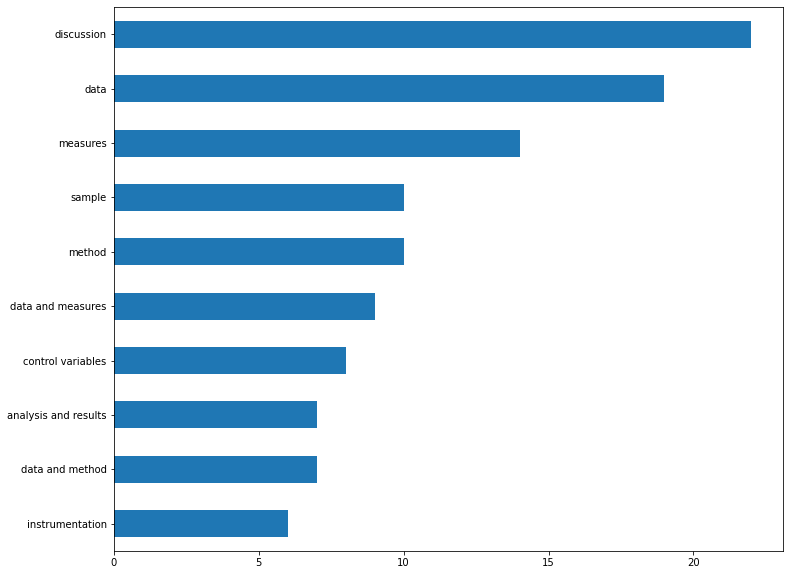

In [6]:
df['clean_section'] = df['paper_section'].apply(clean_text)
df['clean_sentence'] = df['sentence_text'].apply(clean_text)
df['clean_text_referencing_dataset_1'] = df['text_referencing_dataset_1'].apply(clean_text)

df_explode = df.assign(text_referencing_dataset_1=df['text_referencing_dataset_1'].str.split(';')).explode('text_referencing_dataset_1')
df_full = df_explode[df_explode.contains_dataset_1 =="TRUE"]

df_full.clean_section.value_counts().nlargest(10).sort_values().plot(kind='barh',figsize=(12,10))

## What **indicator terms** accompany data citations?

### In paper sections

In [7]:
tokenized_sections = df_full.apply(lambda row: nltk.word_tokenize(row['clean_section']), axis=1)

output = []
for section in tokenized_sections:
    for w in section:
        if w not in stop_words:
            output.append(w)

Counter(" ".join(output).split()).most_common(25)

[('data', 66),
 ('discussion', 27),
 ('measures', 24),
 ('method', 23),
 ('study', 21),
 ('sample', 18),
 ('variables', 15),
 ('results', 14),
 ('control', 10),
 ('curricular', 10),
 ('analysis', 9),
 ('limitations', 9),
 ('conclusion', 8),
 ('quality', 8),
 ('current', 7),
 ('nan', 6),
 ('fatal', 6),
 ('population', 6),
 ('instrumentation', 6),
 ('instruments', 5),
 ('7', 5),
 ('59', 5),
 ('participants', 5),
 ('knowledge', 5),
 ('police', 5)]

Normalize and count section titles

<ipython-input-8-e5fedeea6757>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal['clean_section'] = df_normal['clean_section'].apply(lambda x: func(x))


<AxesSubplot:>

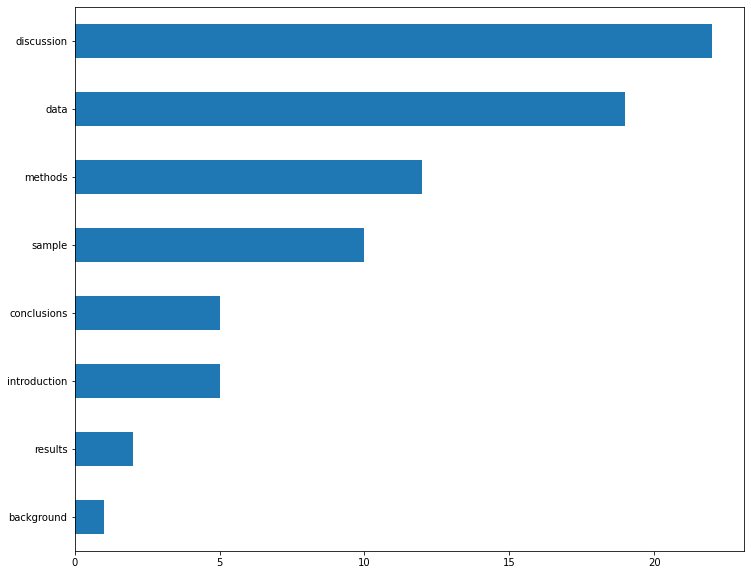

In [8]:
pub_sections = ["title", 
                "abstract", 
                "introduction", 
                "background",
                "method",
                "methods", 
                "methodology",
                "preprocessing",
                "design",
                "analysis",
                "sample", 
                "results", 
                "discussion", 
                "conclusion", 
                "conclusions",
                "summary",
                "references", 
                "data", 
                "material",
                "materials", 
                "supplement",
                "supplements",
                "supplementary",
                "table",
                "tables", 
                "figure",
                "figures",
                "footnote",
                "footnotes",
                "acknowledgement",
                "acknowledgements",
                "appendix",
                "appendices"]

df_normal = df_full.query('clean_section in @pub_sections')

def func(a):
    if "method" in a.lower():
        return "methods"
    elif "methodology" in a.lower():
        return "methods"
    elif "conclusion" in a.lower():
        return "conclusions"
    elif "materials" in a.lower():
        return "material"
    elif "supplements" in a.lower():
        return "supplement"
    elif "supplementary" in a.lower():
        return "supplement"
    elif "figures" in a.lower():
        return "figures"
    elif "footnote" in a.lower():
        return "footnotes"
    elif "figures" in a.lower():
        return "figure"
    elif "tables" in a.lower():
        return "table"
    elif "acknowledgements" in a.lower():
        return "acknowledgement"
    elif "appendices" in a.lower():
        return "appendix"
    else:
        return a

df_normal['clean_section'] = df_normal['clean_section'].apply(lambda x: func(x))

section_counts = df_normal['clean_section'].value_counts().sort_values()
section_counts.plot(kind='barh',figsize=(12,10))

### In dataset labels

In [9]:
tokenized_labels = df_full.apply(lambda row: nltk.word_tokenize(row['clean_text_referencing_dataset_1']), axis=1)

output = []
for section in tokenized_labels:
    for w in section:
        if w not in stop_words:
            output.append(w)

Counter(" ".join(output).split()).most_common(25)

[('ncvs', 56),
 ('ucr', 48),
 ('lemas', 34),
 ('midus', 26),
 ('ecls', 25),
 ('nhats', 24),
 ('k', 21),
 ('hsis', 21),
 ('survey', 20),
 ('national', 19),
 ('2013', 19),
 ('crime', 18),
 ('hsls', 17),
 ('naep', 15),
 ('acs', 15),
 ('faces', 14),
 ('09', 14),
 ('2002', 14),
 ('study', 12),
 ('psid', 12),
 ('supplement', 11),
 ('wrs', 11),
 ('census', 10),
 ('1976', 10),
 ('cds', 10)]

Get scores for frequent and distinctive terms in dataset labels

In [10]:
v = TfidfVectorizer(max_df=.5, min_df=1, stop_words='english', use_idf=True, norm=None)
x = v.fit_transform(df_full['clean_text_referencing_dataset_1']).toarray()

for counter, doc in enumerate(x):
    tf_idf_tuples = list(zip(v.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

one_doc_as_df.head(25)

,term,score
0,hsis,3.571918
1,09,0.000000
2,nhsda,0.000000
3,nass,0.000000
4,national,0.000000
5,ncedl,0.000000
6,nces,0.000000
7,ncrp,0.000000
8,ncvs,0.000000
9,neuroimaging,0.000000


### In sentences containing data citations

In [11]:
tokenized_sentences = df_full.apply(lambda row: nltk.word_tokenize(row['clean_sentence']), axis=1)

output = []
for section in tokenized_sentences:
    for w in section:
        if w not in stop_words:
            output.append(w)

Counter(" ".join(output).split()).most_common(25)

[('data', 115),
 ('ncvs', 57),
 ('study', 51),
 ('ucr', 49),
 ('survey', 48),
 ('sample', 43),
 ('crime', 39),
 ('used', 35),
 ('using', 35),
 ('lemas', 35),
 ('national', 34),
 ('2012', 34),
 ('spring', 34),
 ('2013', 33),
 ('midus', 32),
 ('et', 29),
 ('al', 29),
 ('2011', 26),
 ('nhats', 26),
 ('0', 26),
 ('ecls', 25),
 ('hsis', 25),
 ('community', 24),
 ('k', 23),
 ('reported', 22)]

Get scores for frequent and distinctive terms in sentences that reference datasets

In [12]:
v = TfidfVectorizer(max_df=.5, min_df=1, stop_words='english', use_idf=True, norm=None)
x = v.fit_transform(df_full['clean_sentence']).toarray()

for counter, doc in enumerate(x):
    tf_idf_tuples = list(zip(v.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

one_doc_as_df.head(25)

,term,score
0,curricula,10.553332
1,ease,5.969813
2,implement,5.969813
3,adequacy,5.969813
4,90,5.969813
5,liking,5.969813
6,room,5.969813
7,materials,5.969813
8,leaving,5.969813
9,creativity,5.969813


Let's see if the sentences with data references include terms and phrases indicating data sharing and reuse as predicted by Park et al. (2018). We modify the list as follows and also account for case sensitivity, punctuation:

- "accession" to "access"
- "available at/from" as "available"
- "deposited" as "deposit"
- "donated" as "donate"
- added "nsf", "national science foundation", "grant", "doi"

In [13]:
indicator_terms = ["access", 
                   "available", 
                   ".com", 
                   "commercial", 
                   "Corp.", 
                   "dataset", 
                   "Dataset",
                   "database", 
                   "Database",
                   "deposit",
                   "doi",
                   "DOI",
                   "donated",
                   ".edu",
                   "ftp://", 
                   "gift", 
                   ".gov", 
                   "Inc.", 
                   "National Institutes of Health", 
                   "NIH",
                   "National Science Foundation",
                   "NSF",
                   "grant",
                   "obtained from", 
                   "publicly available", 
                   "purchased from", 
                   "repository",
                   "sample sets",
                   "stored",
                   "suppl", 
                   "Suppl",
                   "Supplemental",
                   "supplemental",
                   "survey"]

ind_pattern = '|'.join(indicator_terms)

def search_pat(search_str:str, search_list:str):
    search_obj = re.search(search_list, search_str)
    if search_obj:
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = 'NA'
    return return_str

df_full['indicator'] = df_full['sentence_text'].apply(lambda x: search_pat(search_str=x, search_list=ind_pattern))
df_full = df_full[df_full.indicator != 'NA']

<ipython-input-13-1a3d30a93bfd>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['indicator'] = df_full['sentence_text'].apply(lambda x: search_pat(search_str=x, search_list=ind_pattern))


<AxesSubplot:>

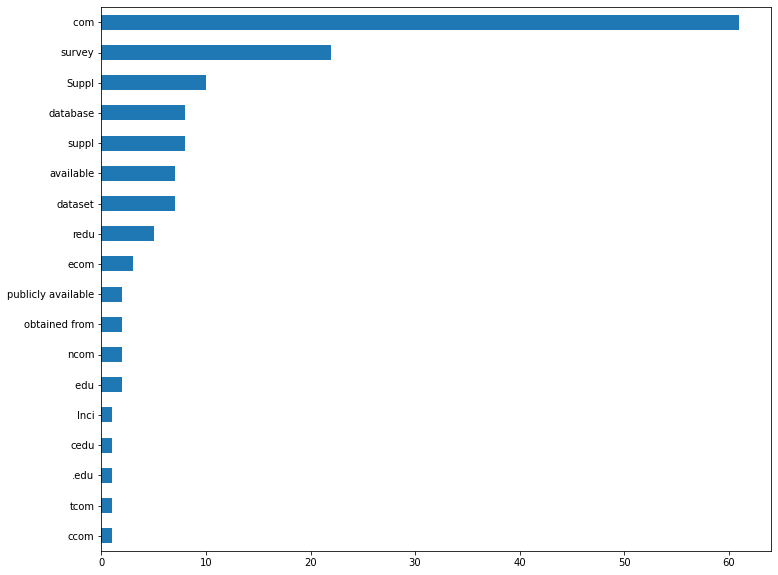

In [14]:
indicator_counts = df_full['indicator'].value_counts().sort_values()
indicator_counts.plot(kind='barh',figsize=(12,10))


## How are data citation sentences constructed?

Full dataframe of citances is too large, so create a random sample for demonstration

In [15]:
# sent_sample = df_full.sample(10)
citances = [x for x in df_full.sentence_text]
citances[0]

'3 This study is based on data from the 2007 ARMS Phase III survey, which used a probability-based, stratifi ed, multiframe sample to provide detailed information on farm businesses and their operators from 18,907 usable questionnaires (Banker 2007) .'

In [16]:
spacy.displacy.render(nlp(str(citances[0])), jupyter=True, style='ent')

In [17]:
doc = nlp(citances[0])
print([(X.text, X.label_) for X in doc.ents])

[('3', 'CARDINAL'), ('2007', 'DATE'), ('ARMS Phase III', 'EVENT'), ('18,907', 'CARDINAL'), ('2007', 'CARDINAL')]


Parsing: "B" means the token begins an entity, "I" means it is inside an entity, "O" means it is outside an entity, and "" means no entity tag is set

In [18]:
print([(X, X.ent_iob_, X.ent_type_) for X in doc])

[(3, 'B', 'CARDINAL'), (This, 'O', ''), (study, 'O', ''), (is, 'O', ''), (based, 'O', ''), (on, 'O', ''), (data, 'O', ''), (from, 'O', ''), (the, 'O', ''), (2007, 'B', 'DATE'), (ARMS, 'B', 'EVENT'), (Phase, 'I', 'EVENT'), (III, 'I', 'EVENT'), (survey, 'O', ''), (,, 'O', ''), (which, 'O', ''), (used, 'O', ''), (a, 'O', ''), (probability, 'O', ''), (-, 'O', ''), (based, 'O', ''), (,, 'O', ''), (stratifi, 'O', ''), (ed, 'O', ''), (,, 'O', ''), (multiframe, 'O', ''), (sample, 'O', ''), (to, 'O', ''), (provide, 'O', ''), (detailed, 'O', ''), (information, 'O', ''), (on, 'O', ''), (farm, 'O', ''), (businesses, 'O', ''), (and, 'O', ''), (their, 'O', ''), (operators, 'O', ''), (from, 'O', ''), (18,907, 'B', 'CARDINAL'), (usable, 'O', ''), (questionnaires, 'O', ''), ((, 'O', ''), (Banker, 'O', ''), (2007, 'B', 'CARDINAL'), (), 'O', ''), (., 'O', '')]


In [19]:
labels = [x.label_ for x in doc.ents]
len(labels)
Counter(labels)

Counter({'CARDINAL': 3, 'DATE': 1, 'EVENT': 1})

In [20]:
items = [x.text for x in doc.ents]
Counter(items).most_common(3)

[('2007', 2), ('3', 1), ('ARMS Phase III', 1)]

In [21]:
dict([(str(x), x.label_) for x in nlp(str(doc)).ents])

{'3': 'CARDINAL',
 '2007': 'CARDINAL',
 'ARMS Phase III': 'EVENT',
 '18,907': 'CARDINAL'}

Define functions for extracting named entities in dataframe

In [27]:
def extract_named_ents(text):
    """Extract named entities, and beginning, middle and end idx using spaCy's out-of-the-box model. 
    
    Keyword arguments:
    text -- the actual text source from which to extract entities
    
    """
#     return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in nlp(text).ents]
    return [(ent.text, ent.label_) for ent in nlp(text).ents]

def add_named_ents(df):
    """Create new column in data frame with named entity tuple extracted.
    
    Keyword arguments:
    df -- a dataframe object
    
    """
#     sent_sample['named_ents'] = sent_sample['sentence_text'].apply(extract_named_ents)  
    df_full['named_ents'] = df_full['sentence_text'].apply(extract_named_ents) 
    
add_named_ents(df_full)

tokens = nlp(''.join(str(df_full.sentence_text.tolist())))
items = [x.label_ for x in tokens.ents]
Counter(items).most_common(20)

[('ORG', 234),
 ('DATE', 177),
 ('CARDINAL', 84),
 ('PERSON', 21),
 ('PERCENT', 21),
 ('GPE', 14),
 ('WORK_OF_ART', 13),
 ('LAW', 11),
 ('NORP', 6),
 ('ORDINAL', 6),
 ('EVENT', 3),
 ('LANGUAGE', 3),
 ('PRODUCT', 2)]

Most common tokens appearing across randomly sampled citances

In [30]:
def find_acronyms(txt):
    """
    finds and returns a sequence of capital letters
    for use on dataset_titles, dataset_labels, or full text
    """
    matches = re.findall(r"\b[A-Z\.]{2,}s?\b", txt)
    if matches:
        return matches
    else:
        return 'None'

def count_acronyms(txt):
    """
    finds and returns a sequence of capital letters
    for use on dataset_titles, dataset_labels, or full text
    """
    matches = re.findall(r"\b[A-Z\.]{2,}s?\b", txt)
    if matches:
        return len(matches)
    else:
        return 0

df_full['find_acronyms'] = df_full['sentence_text'].apply(find_acronyms)
df_full['count_acronyms'] = df_full['sentence_text'].apply(count_acronyms)

acronyms = df_full.find_acronyms.to_list()
acronyms.remove('None')
flat_acronyms = [item for sublist in acronyms for item in sublist]
Counter(flat_acronyms).most_common(25)

[('LEMAS', 30),
 ('UCR', 30),
 ('NCVS', 27),
 ('NHATS', 15),
 ('HSIS', 13),
 ('ACS', 12),
 ('ECLS', 11),
 ('PSID', 10),
 ('N', 9),
 ('o', 9),
 ('n', 9),
 ('e', 9),
 ('CDS', 8),
 ('BWCS', 8),
 ('WRS', 7),
 ('MIDUS', 7),
 ('NSC', 6),
 ('LEAIC', 6),
 ('IPV', 5),
 ('NCRP', 5),
 ('SCS', 5),
 ('BJS', 4),
 ('U.S', 4),
 ('FACES', 4),
 ('LML', 4)]